In [1]:
#Environment used 

#Jupyter lab == 3.6.3
#Python == 3.11.5
#Anaconda == 1.12.1

In [2]:
#scikit-learn == 1.2.2

# Importing Dependancies

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns=1000

from sklearn.preprocessing import LabelEncoder

import warnings 
warnings.filterwarnings('ignore')

## Loading 

In [4]:
train_data=pd.read_csv('training.csv',low_memory=False)
test_data=pd.read_csv('test.csv',low_memory=False)
variable_def=pd.read_csv('Xente_Variable_Definitions.csv')

submission_df=test_data[['TransactionId']].copy()
print(train_data.shape,test_data.shape)

(95662, 16) (45019, 15)


In [5]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


### Analysis

In [6]:
variable_def

,Column Name,Definition
0,TransactionId,Unique �transaction identifier on platform
1,BatchId,Unique number assigned to a batch of transacti...
2,AccountId,Unique number identifying the customer on plat...
3,SubscriptionId,Unique number identifying the customer subscri...
4,CustomerId,Unique identifier attached to Account
5,CurrencyCode,Country currency
6,CountryCode,Numerical geographical code of country
7,ProviderId,Source provider of Item �bought.
8,ProductId,Item name being bought.
9,ProductCategory,ProductIds are organized into these broader pr...


In [7]:
train_data.isnull().sum().sum(),test_data.isnull().sum().sum() #no null values in both our data sets

(0, 0)

##### categorical_columns

In [8]:
categorical_columns=train_data.select_dtypes(include='object').columns
train_data[categorical_columns].apply(lambda y:len(y.unique()))

TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
CurrencyCode                1
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
TransactionStartTime    94556
dtype: int64

##### Numerical_columns

In [9]:
train_data.FraudResult.value_counts()# imbalanced target values [nonfraud transactions tend to dominate the dataset]

FraudResult
0    95469
1      193
Name: count, dtype: int64

In [10]:
train_data.CountryCode.value_counts()#uganda same as the country currency

CountryCode
256    95662
Name: count, dtype: int64

In [11]:
train_data.PricingStrategy.value_counts()

PricingStrategy
2    79848
4    13562
1     1867
0      385
Name: count, dtype: int64

# Visualization

In [12]:
visualize_categ=['ProviderId','ProductId','ProductCategory','ChannelId']

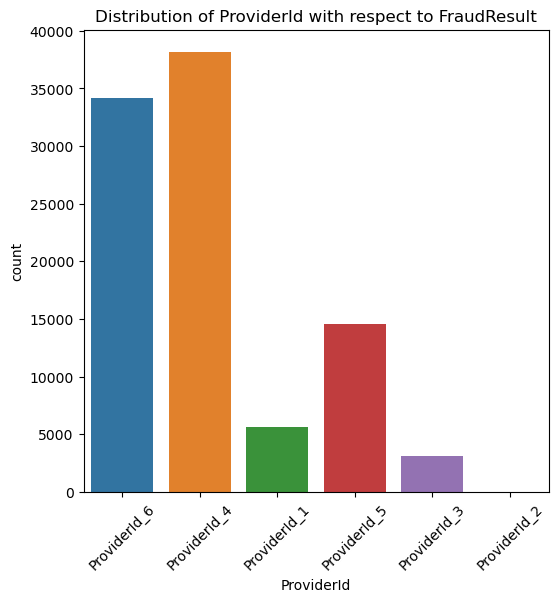

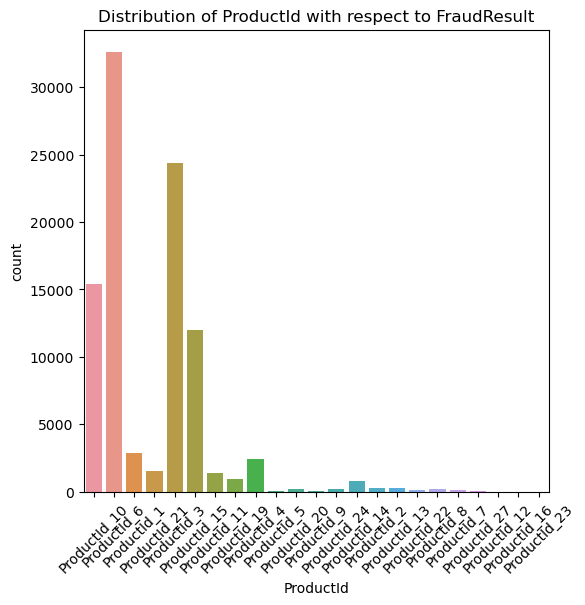

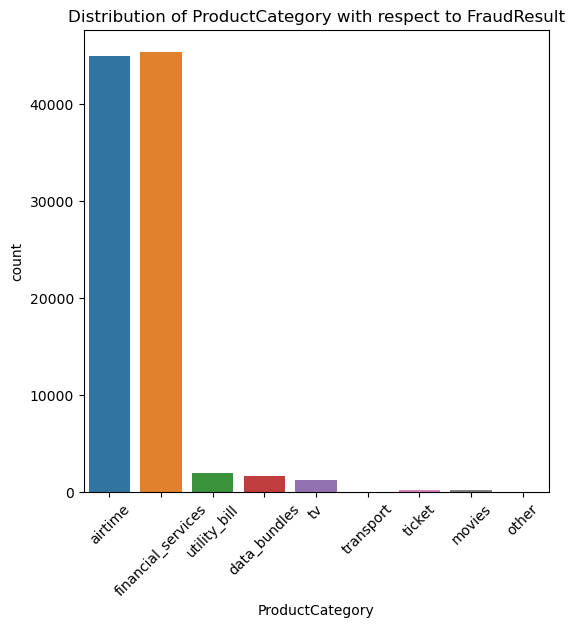

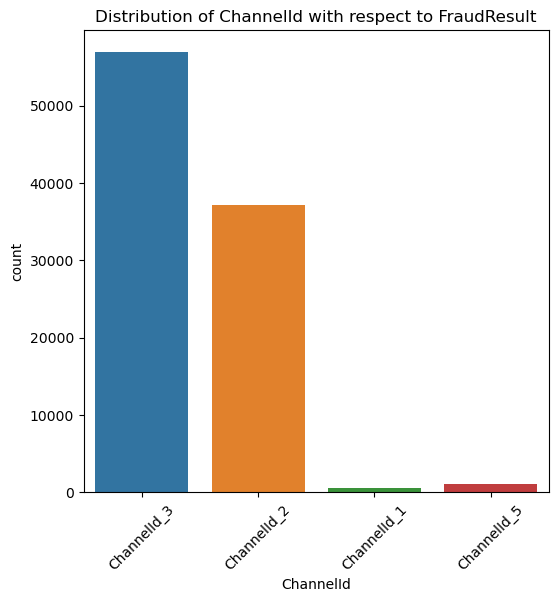

In [13]:
for cols in visualize_categ:
    plt.figure(figsize=(6,6))
    sns.countplot(x=cols,data=train_data)
    plt.title('Distribution of {} with respect to FraudResult'.format(cols))
    plt.xticks(rotation=45)

#### Visualize target

<Axes: xlabel='FraudResult', ylabel='count'>

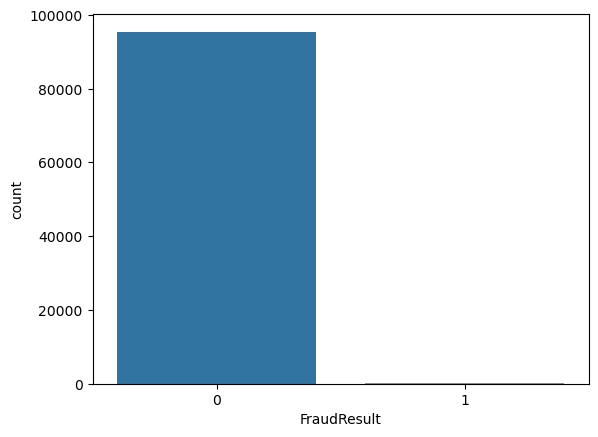

In [14]:
sns.countplot(x=train_data.FraudResult,data=train_data) #Highly imbalanced

In [15]:
(train_data['FraudResult']==1).sum(),(train_data['FraudResult']==0).sum()

(193, 95469)

##### numerical column distributions

In [16]:
numerical_columns=[columns for columns in train_data.select_dtypes(exclude='object') if columns not in ['FraudResult','CountryCode']]

numerical_columns

['Amount', 'Value', 'PricingStrategy']

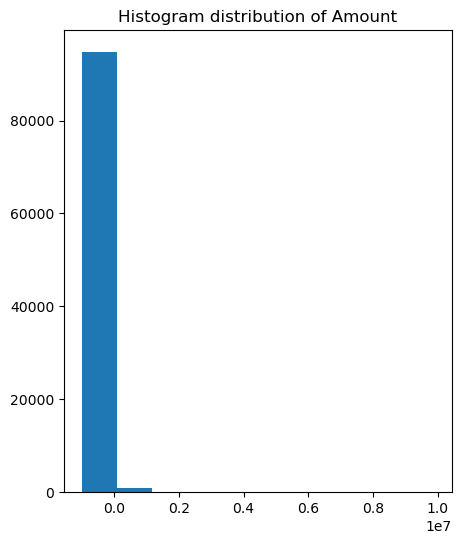

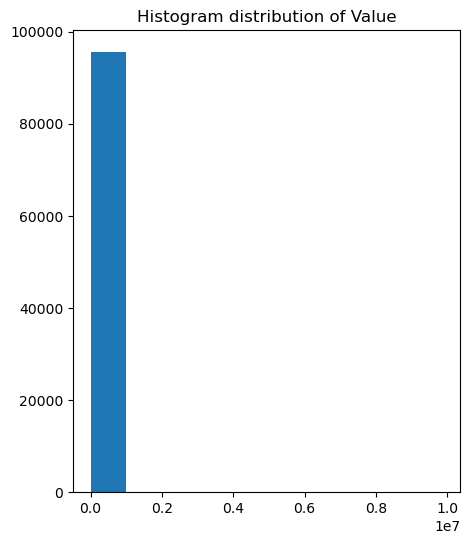

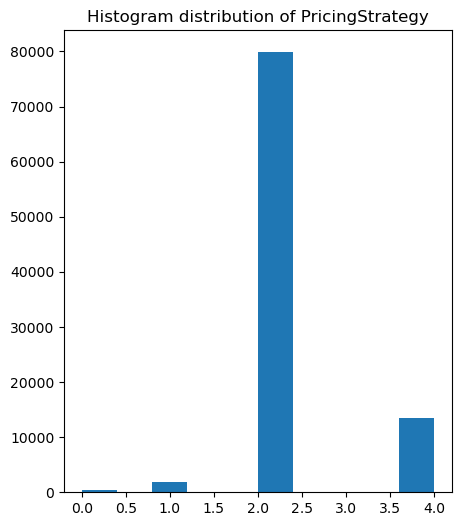

In [17]:
for col in numerical_columns:
    plt.figure(figsize=(5,6))
    plt.hist(train_data[col])
    plt.title('Histogram distribution of {}'.format(col))

## Date Features

In [18]:
train_data['TransactionStartTime']=pd.to_datetime(train_data['TransactionStartTime'])
test_data['TransactionStartTime']=pd.to_datetime(test_data['TransactionStartTime'])
train_data.TransactionStartTime.head(2)

0   2018-11-15 02:18:49+00:00
1   2018-11-15 02:19:08+00:00
Name: TransactionStartTime, dtype: datetime64[ns, UTC]

In [19]:
#train_data['Year']=train_data.TransactionStartTime.dt.year.astype(str)# the hot encode
train_data['month']=train_data.TransactionStartTime.dt.month
train_data['day']=train_data.TransactionStartTime.dt.day
train_data['hour']=train_data.TransactionStartTime.dt.hour
train_data['week_day']=train_data.TransactionStartTime.dt.weekday

In [20]:
date_features=['month','day','week_day','hour']
train_data[date_features].apply(lambda x:x.unique())

month                                          [11, 12, 1, 2]
day         [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...
week_day                                [3, 4, 5, 6, 0, 1, 2]
hour        [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...
dtype: object

###### For test data

In [21]:
#test_data['Year']=test_data.TransactionStartTime.dt.year.astype(str)# the hot encode
test_data['month']=test_data.TransactionStartTime.dt.month
test_data['day']=test_data.TransactionStartTime.dt.day
test_data['hour']=test_data.TransactionStartTime.dt.hour
test_data['week_day']=test_data.TransactionStartTime.dt.weekday

In [22]:
date_features=['month','day','week_day','hour']
test_data[date_features].apply(lambda x:x.unique())

month                                                  [2, 3]
day         [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2...
week_day                                [2, 3, 4, 5, 6, 0, 1]
hour        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...
dtype: object

In [23]:
#year column in test include one value so  I opted to drop it in both datasets

In [24]:
drop_columns=['TransactionId','CountryCode','CurrencyCode','Amount','TransactionStartTime','AccountId','SubscriptionId','CustomerId','BatchId']

train=train_data.drop(drop_columns,axis=1)
test=test_data.drop(drop_columns,axis=1)

# One Encoding

In [25]:
convert=LabelEncoder()

le_columns=['ProviderId','ProductId','ProductCategory','ChannelId']

for column in le_columns:
    train[column]=convert.fit_transform(train[column])
    test[column]=convert.fit_transform(test[column])

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ProviderId       95662 non-null  int32
 1   ProductId        95662 non-null  int32
 2   ProductCategory  95662 non-null  int32
 3   ChannelId        95662 non-null  int32
 4   Value            95662 non-null  int64
 5   PricingStrategy  95662 non-null  int64
 6   FraudResult      95662 non-null  int64
 7   month            95662 non-null  int32
 8   day              95662 non-null  int32
 9   hour             95662 non-null  int32
 10  week_day         95662 non-null  int32
dtypes: int32(8), int64(3)
memory usage: 5.1 MB


In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45019 entries, 0 to 45018
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ProviderId       45019 non-null  int32
 1   ProductId        45019 non-null  int32
 2   ProductCategory  45019 non-null  int32
 3   ChannelId        45019 non-null  int32
 4   Value            45019 non-null  int64
 5   PricingStrategy  45019 non-null  int64
 6   month            45019 non-null  int32
 7   day              45019 non-null  int32
 8   hour             45019 non-null  int32
 9   week_day         45019 non-null  int32
dtypes: int32(8), int64(2)
memory usage: 2.1 MB


### split

In [28]:
X=train.drop('FraudResult',axis=1)
y=train.FraudResult

### Feature selection

<Axes: >

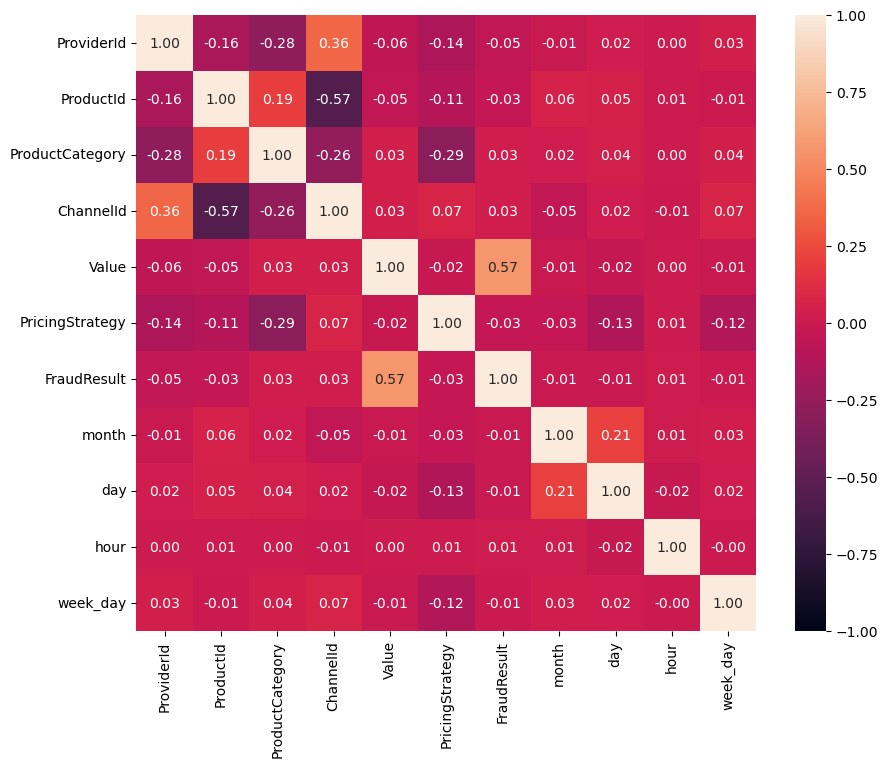

In [29]:
correlation=train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,vmin=-1,vmax=1,fmt='.02f')

In [30]:
#The correlation matrix helped identify the independent variables that were highly correlated to each other while adding new features

### Split

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train.shape,y_train.shape

((76529, 10), (76529,))

### StartifiedKFold

In [32]:
from sklearn.model_selection import  StratifiedKFold

fold=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

for train_index,test_index in fold.split(X,y):
    X_train_k,X_test_k=X.iloc[train_index],X.iloc[test_index]
    y_train_k,y_test_k=y.iloc[train_index],y.iloc[test_index]

X_train_k.shape,X_test_k.shape

((76530, 10), (19132, 10))

### Applying SMOTE

In [33]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

Smote_algorithim=SMOTEENN()
X_train_balanced,y_train_balanced=Smote_algorithim.fit_resample(X_train_k,y_train_k)
X_train_balanced.shape,y_train_balanced.shape

((149993, 10), (149993,))

#### Tree Classifiers Params

In [34]:
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]
#number of iterations
estimators = [400,300,200,100]

#### Randomize Search

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_params={
    'n_estimators':estimators,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf
}
srf_model=RandomForestClassifier()
Random_cv=RandomizedSearchCV(srf_model,rf_params,cv=5,n_jobs=-1,scoring='roc_auc',n_iter=20,verbose=2)
Random_cv.fit(X_train_k,y_train_k)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 9, 11, 13, 15],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              50, 100],
                                        'n_estimators': [400, 300, 200, 100]},
                   scoring='roc_auc', verbose=2)

In [36]:
rf_best=Random_cv.best_params_
rf_best

{'n_estimators': 100,
 'min_samples_split': 50,
 'min_samples_leaf': 5,
 'max_depth': 15}

# RandomForestClassifier

In [37]:
from sklearn.ensemble import RandomForestClassifier
#Tried tunning to different best parameters  which produced the highest score on the public lb

rf_model=RandomForestClassifier(n_estimators=200,max_depth=15,min_samples_split=5,min_samples_leaf=5,random_state=1)
rf_model.fit(X_train_k,y_train_k)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=200, random_state=1)

In [38]:
preds=rf_model.predict(X_test_k)
classification_report(y_test_k,preds,output_dict=True)

{'0': {'precision': 0.9997905101078873,
  'recall': 0.9998428743518567,
  'f1-score': 0.9998166915442428,
  'support': 19093},
 '1': {'precision': 0.9210526315789473,
  'recall': 0.8974358974358975,
  'f1-score': 0.9090909090909091,
  'support': 39},
 'accuracy': 0.9996341208446582,
 'macro avg': {'precision': 0.9604215708434174,
  'recall': 0.9486393858938771,
  'f1-score': 0.954453800317576,
  'support': 19132},
 'weighted avg': {'precision': 0.9996300053377312,
  'recall': 0.9996341208446582,
  'f1-score': 0.9996317497966115,
  'support': 19132}}

In [39]:
f1_score(y_test_k,preds),precision_score(y_test_k,preds),recall_score(y_test_k,preds)

(0.9090909090909091, 0.9210526315789473, 0.8974358974358975)

In [40]:
rf_predictions=rf_model.predict(test)
rf_predictions=pd.DataFrame(rf_predictions,columns=['target'])

In [41]:
ss=pd.read_csv('sample_submission.csv')

In [42]:
rf_submission=pd.DataFrame({
    "TransactionId":ss.TransactionId,
    "FraudResult":rf_predictions.target
})

In [43]:
rf_submission.FraudResult.value_counts()

FraudResult
0    44941
1       78
Name: count, dtype: int64

In [44]:
#rf_submission.to_csv('submission_46_rf.csv',index=False)